In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from datetime import datetime


In [2]:
# Load the pre-trained ResNet-50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(40, 862, 3))  # Change input_shape to have 3 channels

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for your audio classification task
x = layers.Flatten()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation='softmax')(x)  # 2 classes (change if needed)


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:

# Create the fine-tuned model
model = Model(inputs=base_model.input, outputs=output)
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Display model architecture summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 862, 3)]         0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 46, 868, 3)           0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 20, 431, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 20, 431, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Load your dataset
train_dataset = pd.read_pickle("/content/drive/MyDrive/FYP2/train.csv")
validation_dataset = pd.read_pickle("/content/drive/MyDrive/FYP2/validate.csv")
X_train = np.array(train_dataset.feature.tolist())
y_train = np.array(train_dataset.class_label.tolist())
X_validation = np.array(validation_dataset.feature.tolist())
y_validation = np.array(validation_dataset.class_label.tolist())


In [ ]:
# Encode the classification labels
le = LabelEncoder()
yy_train = to_categorical(le.fit_transform(y_train))
yy_validation = to_categorical(le.fit_transform(y_validation))


In [ ]:
# Data reshaping for ResNet-50
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)  # Repeat the single channel to create three channels
X_validation = np.repeat(X_validation[..., np.newaxis], 3, -1)

# Shuffle the data
X_train, yy_train = shuffle(X_train, yy_train, random_state=42)


In [ ]:
# Train the model
num_epochs = 20
num_batch_size = 64
start = datetime.now()
history = model.fit(X_train, yy_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(X_validation, yy_validation), verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/20
68/68 [==============================] - 24s 230ms/step - loss: 1.3009 - accuracy: 0.5525 - val_loss: 0.6584 - val_accuracy: 0.5651
Epoch 2/20
68/68 [==============================] - 14s 200ms/step - loss: 0.6544 - accuracy: 0.5948 - val_loss: 0.6216 - val_accuracy: 0.6729
Epoch 3/20
68/68 [==============================] - 12s 183ms/step - loss: 0.6365 - accuracy: 0.6231 - val_loss: 0.6257 - val_accuracy: 0.6822
Epoch 4/20
68/68 [==============================] - 14s 201ms/step - loss: 0.6214 - accuracy: 0.6350 - val_loss: 0.6027 - val_accuracy: 0.7156
Epoch 5/20
68/68 [==============================] - 13s 184ms/step - loss: 0.6142 - accuracy: 0.6106 - val_loss: 0.5889 - val_accuracy: 0.7286
Epoch 6/20
68/68 [==============================] - 14s 205ms/step - loss: 0.5906 - accuracy: 0.6327 - val_loss: 0.5733 - val_accuracy: 0.7379
Epoch 7/20
68/68 [==============================] - 13s 188ms/step - loss: 0.5586 - accuracy: 0.6468 - val_loss: 0.5356 - val_accuracy: 0.7361

In [ ]:
model.save('/content/drive/MyDrive/CNN/Resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from tensorflow.keras.models import load_model
import numpy as np  # Assuming you have input data in a NumPy array

# Load the model from the .h5 file
model = load_model('/content/drive/MyDrive/CNN/Resnet.h5')

In [4]:

# Load your testing dataset
testing_dataset = pd.read_pickle("/content/drive/MyDrive/FYP2/test.csv")

X_test = np.array(testing_dataset.feature.tolist())
y_test = np.array(testing_dataset.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy_test = to_categorical(le.fit_transform(y_test))

In [5]:

# Data reshaping for ResNet-50
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)


In [6]:
# Evaluate the model on the testing dataset
loss, accuracy = model.evaluate(X_test, yy_test)
print(f'Testing Loss: {loss:.4f}')
print(f'Testing Accuracy: {accuracy:.4f}')


17/17 [==============================] - 12s 136ms/step - loss: 0.3923 - accuracy: 0.8309
Testing Loss: 0.3923
Testing Accuracy: 0.8309


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

NameError: ignored

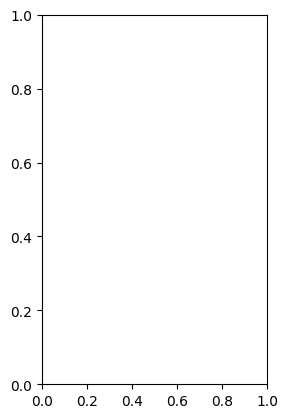

In [ ]:

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')


In [8]:
# Predictions on the testing dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(yy_test, axis=1)


17/17 [==============================] - 3s 83ms/step


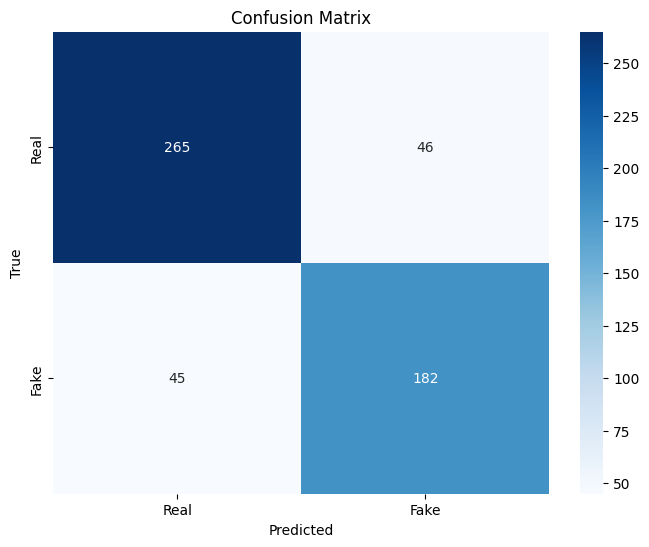

Classification Report:
              precision    recall  f1-score   support

        Real       0.85      0.85      0.85       311
        Fake       0.80      0.80      0.80       227

    accuracy                           0.83       538
   macro avg       0.83      0.83      0.83       538
weighted avg       0.83      0.83      0.83       538



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true_classes and y_pred_classes are your true and predicted labels
# Map numerical labels to string labels
label_mapping = {0: 'Real', 1: 'Fake'}
y_true_labels = [label_mapping[label] for label in y_true_classes]
y_pred_labels = [label_mapping[label] for label in y_pred_classes]

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report for additional metrics
report = classification_report(y_true_labels, y_pred_labels, target_names=['Real', 'Fake'])
print("Classification Report:")
print(report)
